# Tutorial 2. A Simple Toy Regression

This is a quick example showing how one can use the concepts introduced in Tutorial 1 (Basics) to do a quick toy regression.

The problem we are dealing with is a very simple one, with two-dimensional input `x` and one-dimensional output `y`, and a weight vector `w=[2.0, 1.5]` and bias `b=0.5`. The equation to generate ground truth is:

```y = wx + b```

For this tutorial, we will be generating training data using Caffe2 operators as well. Note that this is usually not the case in your daily training jobs: in a real training scenario data is usually loaded from an external source, such as a Caffe DB (i.e. a key-value storage) or a Hive table. We will cover this in the MNIST tutorial.

We will write out every piece of math in Caffe2 operators. This is often an overkill if your algorithm is relatively standard, such as CNN models. In the MNIST tutorial, we will show how to use the CNN model helper to more easily construct CNN models.

In [1]:
from caffe2.python import core, cnn, net_drawer, workspace, visualize
import numpy as np
from IPython import display
from matplotlib import pyplot

ERROR:root:This caffe2 python run does not have GPU support. Error: No module named libcaffe2_python_gpu


Couldn't import dot_parser, loading of dot files will not be possible.


## Declaring the computation graphs

There are two graphs that we declare: one is used to initialize the various parameters and constants that we are going to use in the computation, and another main graph that is used to run stochastic gradient descent.

First, the init net: note that the name does not matter, we basically want to put the initialization code in one net so we can then call RunNetOnce() to execute it. The reason we have a separate init_net is that, these operators do not need to run more than once for the whole training procedure.

In [2]:
init_net = core.Net("init")
# The ground truth parameters.
W_gt = init_net.GivenTensorFill(
    [], "W_gt", shape=[1, 2], values=[2.0, 1.5])
B_gt = init_net.GivenTensorFill([], "B_gt", shape=[1], values=[0.5])
# Constant value ONE is used in weighted sum when updating parameters.
ONE = init_net.ConstantFill([], "ONE", shape=[1], value=1.)
# ITER is the iterator count.
ITER = init_net.ConstantFill([], "ITER", shape=[1], value=0, dtype=core.DataType.INT32)

# For the parameters to be learned: we randomly initialize weight
# from [-1, 1] and init bias with 0.0.
W = init_net.UniformFill([], "W", shape=[1, 2], min=-1., max=1.)
B = init_net.ConstantFill([], "B", shape=[1], value=0.0)
print('Created init net.')

Created init net.


The main training network is defined as follows. We will show the creation in multiple steps:
- The forward pass that generates the loss
- The backward pass that is generated by auto differentiation.
- The parameter update part, which is a standard SGD.

In [3]:
train_net = core.Net("train")
# First, we generate random samples of X and create the ground truth.
X = train_net.GaussianFill([], "X", shape=[64, 2], mean=0.0, std=1.0, run_once=0)
Y_gt = X.FC([W_gt, B_gt], "Y_gt")
# We add Gaussian noise to the ground truth
noise = train_net.GaussianFill([], "noise", shape=[64, 1], mean=0.0, std=1.0, run_once=0)
Y_noise = Y_gt.Add(noise, "Y_noise")
# Note that we do not need to propagate the gradients back through Y_noise,
# so we mark StopGradient to notify the auto differentiating algorithm
# to ignore this path.
Y_noise = Y_noise.StopGradient([], "Y_noise")

# Now, for the normal linear regression prediction, this is all we need.
Y_pred = X.FC([W, B], "Y_pred")

# The loss function is computed by a squared L2 distance, and then averaged
# over all items in the minibatch.
dist = train_net.SquaredL2Distance([Y_noise, Y_pred], "dist")
loss = dist.AveragedLoss([], ["loss"])

Now, let's take a look at what the whole network looks like. From the graph below, you can find that it is mainly composed of four parts:

- Randomly generate X for this batch (GaussianFill that generates X)
- Use W_gt, B_gt and the FC operator to generate the ground truth Y_gt
- Use the current parameters, W and B, to make predictions.
- Compare the outputs and compute the loss.

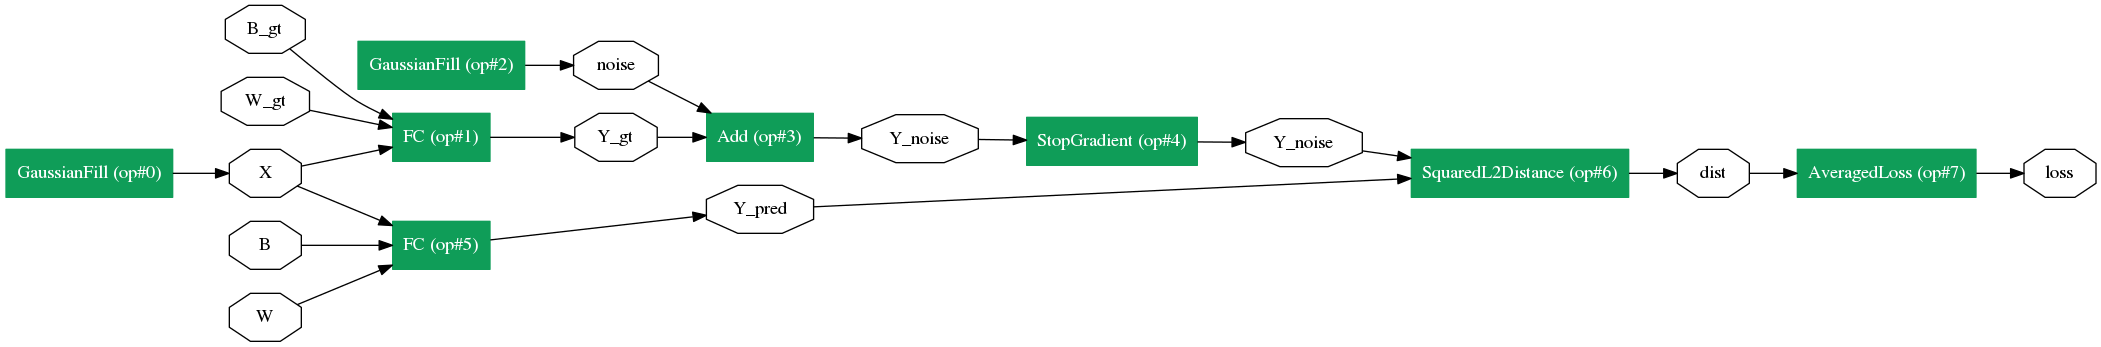

In [4]:
graph = net_drawer.GetPydotGraph(train_net.Proto().op, "train", rankdir="LR")
display.Image(graph.create_png(), width=800)

Now, similar to all other frameworks, Caffe2 allows us to automatically generate the gradient operators. let's do so and then look at what the graph becomes.

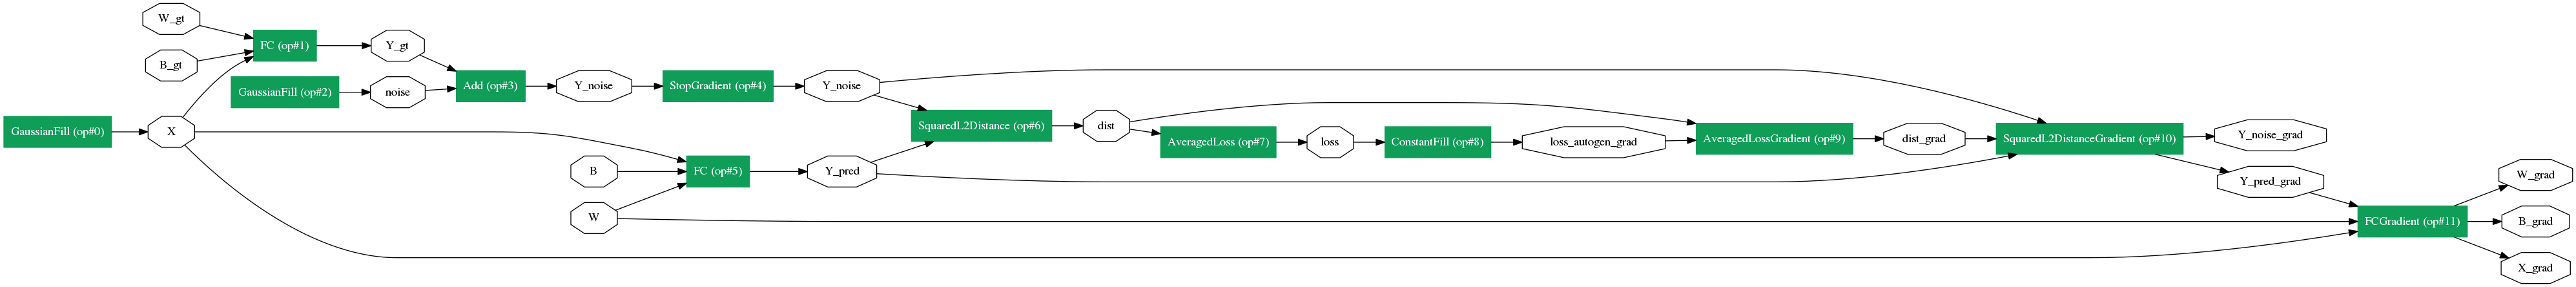

In [5]:
# Get gradients for all the computations above.
gradient_map = train_net.AddGradientOperators([loss])
graph = net_drawer.GetPydotGraph(train_net.Proto().op, "train", rankdir="LR")
display.Image(graph.create_png(), width=800)

Once we get the gradients for the parameters, we will add the SGD part of the graph: get the learning rate of the current step, and then do parameter updates. We are not doing anything fancy in this example: just simple SGDs.

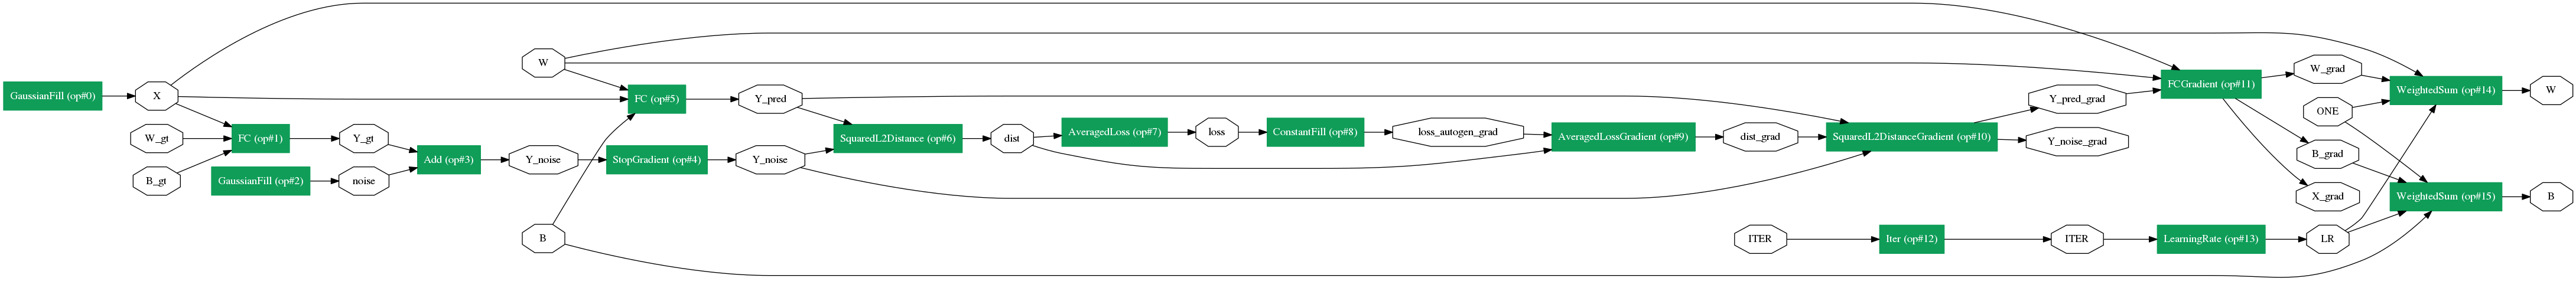

In [6]:
# Increment the iteration by one.
train_net.Iter(ITER, ITER)
# Compute the learning rate that corresponds to the iteration.
LR = train_net.LearningRate(ITER, "LR", base_lr=-0.1,
                            policy="step", stepsize=20, gamma=0.9)

# Weighted sum 
train_net.WeightedSum([W, ONE, gradient_map[W], LR], W)
train_net.WeightedSum([B, ONE, gradient_map[B], LR], B)

# Let's show the graph again.
graph = net_drawer.GetPydotGraph(train_net.Proto().op, "train", rankdir="LR")
display.Image(graph.create_png(), width=800)

Now that we have created the networks, let's run them.

In [7]:
workspace.RunNetOnce(init_net)
workspace.CreateNet(train_net)

True

Before we start any training iterations, let's take a look at the parameters.

In [8]:
print("Before training, W is: {}".format(workspace.FetchBlob("W")))
print("Before training, B is: {}".format(workspace.FetchBlob("B")))

Before training, W is: [[-0.77634162 -0.88467366]]
Before training, B is: [ 0.]


In [9]:
for i in range(100):
    workspace.RunNet(train_net.Proto().name)

Now, let's take a look at the parameters after training.

In [10]:
print("After training, W is: {}".format(workspace.FetchBlob("W")))
print("After training, B is: {}".format(workspace.FetchBlob("B")))

print("Ground truth W is: {}".format(workspace.FetchBlob("W_gt")))
print("Ground truth B is: {}".format(workspace.FetchBlob("B_gt")))

After training, W is: [[ 1.95769441  1.47348857]]
After training, B is: [ 0.45236012]
Ground truth W is: [[ 2.   1.5]]
Ground truth B is: [ 0.5]


Looks simple enough right? Let's take a closer look at the progression of the parameter updates over the training steps. For this, let's re-initialize the parameters, and look at the change of the parameters over the steps. Remember, we can fetch blobs from the workspace whenever we want.

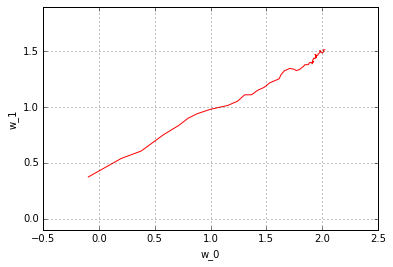

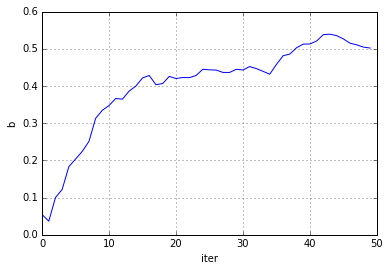

In [11]:
workspace.RunNetOnce(init_net)
w_history = []
b_history = []
for i in range(50):
    workspace.RunNet(train_net.Proto().name)
    w_history.append(workspace.FetchBlob("W"))
    b_history.append(workspace.FetchBlob("B"))
w_history = np.vstack(w_history)
b_history = np.vstack(b_history)
pyplot.plot(w_history[:, 0], w_history[:, 1], 'r')
pyplot.axis('equal')
pyplot.xlabel('w_0')
pyplot.ylabel('w_1')
pyplot.grid(True)
pyplot.figure()
pyplot.plot(b_history)
pyplot.xlabel('iter')
pyplot.ylabel('b')
pyplot.grid(True)

You can observe the very typical behavior of a stochastic gradient descent: due to noise things fluctuates quite a bit over the whole training procedure. Try running the above ipython notebook block multiple times - you'll see the effect of different initializations and different noises.

Of course, this is a toy data case - in the MNIST example we will show a more real-world example of NN training.